In [1]:
pip install keras-cv

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/650.7 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/650.7 kB ? eta -:--:--
   ---------------------------------------- 650.7/650.7 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/950.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/950.8 kB ? eta -:--:--
   ---------------------- ----------------- 524.3/950.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 950.8/950.8 kB 1.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:--
   --- ------------------------------------ 0.5/5.3 MB 1.5 MB/s eta 0:00:04
   ----- ---------------------------------- 0.8/5.3 MB 1.5 MB/s eta 0:00:03
   --------- ------------------------------ 1.3/5.3 MB 1.6 MB/s eta 0:00:03
   -

In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Folder paths
input_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/plots"
output_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/matrix"

input_size = (400, 1000)  # (width, height)
output_size = (50, 50)

X_data = []
Y_data = []

# Loop over possible X values from 1 to 1500
for i in range(1, 1501):
    input_path = os.path.join(input_dir, f"graph_{i}.png")
    output_path = os.path.join(output_dir, f"{i}.png")

    # Check if both input and output files exist
    if os.path.exists(input_path) and os.path.exists(output_path):
        # Load and preprocess input image
        in_img = Image.open(input_path).convert("L").resize(input_size)
        in_arr = np.array(in_img) / 255.0
        X_data.append(in_arr)

        # Load and preprocess output image
        out_img = Image.open(output_path).convert("L").resize(output_size)
        out_arr = np.array(out_img) / 255.0
        Y_data.append(out_arr)
    else:
        # Skipping this pair because one of them is missing
        continue

# Convert to NumPy arrays and reshape for CNN
X_data = np.array(X_data).reshape(-1, 1000, 400, 1)
Y_data = np.array(Y_data).reshape(-1, 50, 50, 1)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

print(f"✅ Total usable pairs found: {len(X_data)}")

✅ Total usable pairs found: 1161


In [2]:
X_data.shape  # (samples, 1000, 400, 1)
Y_data.shape  # (samples, 50, 50, 1)


(1161, 50, 50, 1)

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Resizing
from PIL import Image

# Paths
input_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/plots"    # your input image folder (1000x400)
output_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/resized_plots_256"  # where resized images will be saved
os.makedirs(output_dir, exist_ok=True)

# Resizer layer
resizer = Resizing(256, 256)

# Loop over image files
for i in range(1, 1501):
    img_path = os.path.join(input_dir, f"graph_{i}.png")
    if not os.path.exists(img_path):
        continue  # skip missing

    img = Image.open(img_path).convert("L")  # grayscale
    img_array = np.array(img) / 255.0        # normalize to [0, 1]
    img_tensor = tf.expand_dims(img_array, axis=-1)
    resized = resizer(img_tensor)
    
    save_path = os.path.join(output_dir, f"{i}.npy")
    np.save(save_path, resized.numpy())


In [8]:
import random

def load_batch(image_ids, folder):
    return np.array([
        np.load(os.path.join(folder, f"{i}.npy")) for i in image_ids
    ])

# Example:
train_ids = [1, 2, 3, 5, 8, 12, 13]  # only valid image IDs
X_batch = load_batch(train_ids, "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/resized_plots_256")


In [6]:
from tensorflow.keras.layers import Layer, Dense, LayerNormalization

class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = self.add_weight(
            name="position_embedding",
            shape=(1, num_patches, projection_dim),
            initializer="random_normal"
        )

    def call(self, patch):
        x = self.projection(patch)
        return x + self.position_embedding


In [4]:
from tensorflow.keras import layers, models, Model
import tensorflow as tf

def create_vit_autoencoder(input_shape=(256, 256, 1), patch_size=16, projection_dim=64, transformer_layers=4):
    inputs = layers.Input(shape=input_shape)
    
    # 1. Patch the image
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_dim = patch_size * patch_size

    x = layers.Conv2D(filters=projection_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid')(inputs)  # [batch, 16, 16, projection_dim]
    x = layers.Reshape((num_patches, projection_dim))(x)  # Flatten patches

    # 2. Add positional encoding
    x = PatchEncoder(num_patches, projection_dim)(x)

    # 3. Transformer encoder
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization()(x)
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([x, attention_output])
        x3 = layers.LayerNormalization()(x2)
        mlp_output = layers.Dense(projection_dim, activation='relu')(x3)
        x = layers.Add()([x2, mlp_output])

    # 4. Decoder head to image
    x = layers.Flatten()(x)
    x = layers.Dense(2500, activation='sigmoid')(x)
    outputs = layers.Reshape((50, 50, 1))(x)

    return Model(inputs, outputs)


In [11]:
vit_model = create_vit_autoencoder()
vit_model.compile(optimizer='adam', loss='mse')
vit_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 16, 16, 64)        │          16,448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 256, 64)           │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ patch_encoder (PatchEncoder)  │ (None, 256, 64)           │          20,544 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 256, 64)           │             128 │ patch_encoder[0][0]        │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 256, 64)           │          66,368 │ layer_normalization[0][0], │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256, 64)           │               0 │ patch_encoder[0][0],       │
│                               │                           │                 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 256, 64)           │             128 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256, 64)           │           4,160 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 256, 64)           │               0 │ add[0][0], dense_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 256, 64)           │             128 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 256, 64)           │          66,368 │ layer_normalization_2[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 256, 64)           │               0 │ add_1[0][0],               │
│                               │                           │                 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_3         │ (None, 256, 64)           │             12

 Total params: 41,282,628 (157.48 MB)

 Trainable params: 41,282,628 (157.48 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
print(X_train.shape)  # Must be (samples, 256, 256, 1)


(928, 1000, 400, 1)


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing
import numpy as np

resizer = Resizing(256, 256)

# Use tf.stack for memory efficiency
X_train_resized = tf.stack([resizer(img) for img in tf.convert_to_tensor(X_train)])
X_test_resized  = tf.stack([resizer(img) for img in tf.convert_to_tensor(X_test)])


In [15]:
print(X_train_resized.shape)

(928, 256, 256, 1)


In [7]:
# Step 1: Import + resize
import tensorflow as tf
from tensorflow.keras.layers import Resizing
resizer = Resizing(256, 256)

X_train_resized = tf.stack([resizer(img) for img in tf.convert_to_tensor(X_train)])
X_test_resized  = tf.stack([resizer(img) for img in tf.convert_to_tensor(X_test)])

# Step 2: Recreate the model
vit_model = create_vit_autoencoder()  # Your custom ViT code
vit_model.compile(optimizer='adam', loss='mse')

# Step 3: Train (first call must build the full graph!)
vit_model.fit(
    X_train_resized, Y_train,
    validation_data=(X_test_resized, Y_test),
    epochs=50,
    batch_size=16
)



Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 418ms/step - loss: 0.4885 - val_loss: 0.4995
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 400ms/step - loss: 0.4990 - val_loss: 0.4994
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 396ms/step - loss: 0.4997 - val_loss: 0.4994
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step - loss: 0.4990 - val_loss: 0.4994
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 402ms/step - loss: 0.4997 - val_loss: 0.4994
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 409ms/step - loss: 0.4995 - val_loss: 0.4994
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 400ms/step - loss: 0.4992 - val_loss: 0.4994
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 390ms/step - loss: 0.4991 - val_loss: 0.4994
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 394ms/step - loss: 0.4991 - val_loss: 0.4994
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 387ms/step - loss: 0.4996 - val_loss: 0.4994
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 395ms/step - loss: 0.4997 - val_loss: 0.4994
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2

In [9]:
predicted = vit_model.predict(X_test_resized)
predicted_images = predicted.reshape((-1, 50, 50))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


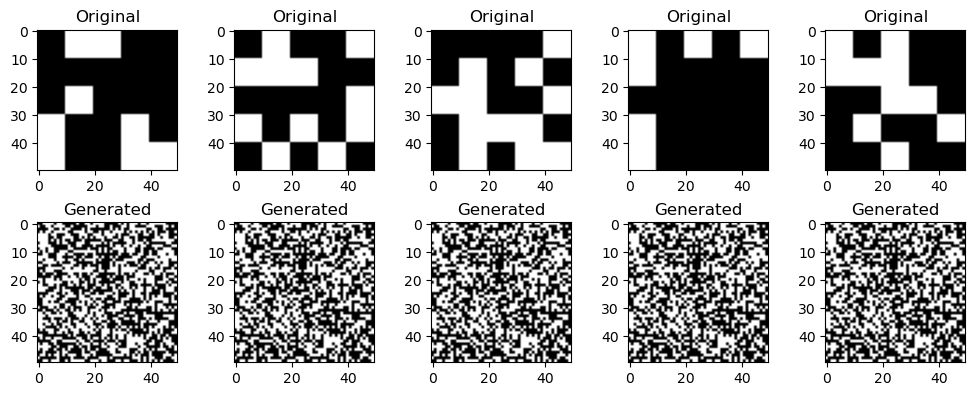

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(Y_test[i].reshape(50, 50), cmap='gray')
    plt.title("Original")
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(predicted_images[i], cmap='gray')
    plt.title("Generated")

plt.tight_layout()
plt.show()